# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing, model_selection
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
!pip install simpletransformers

In [14]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd '/content/drive/MyDrive/SEM3/'

/content/drive/MyDrive/SEM3


# Reading data

In [4]:
# Reading the dataset.
df = pd.read_csv('combined.csv')
df.shape

(28619, 4)

In [5]:
print(df.isna().sum())
df.dropna(inplace=True)
print("\nShape after removing null-values", df.shape)

is_sarcastic       0
headline           0
article_link       0
article_text    4379
dtype: int64

Shape after removing null-values (24240, 4)


In [6]:
df.columns

Index(['is_sarcastic', 'headline', 'article_link', 'article_text'], dtype='object')

In [7]:
id = 4

line1 = df['headline'].iloc[id]
line2 = df['article_text'].iloc[id]
print(line1)
print()
print(len(line2.split()))
print(line2)

line_link = df['article_link'].iloc[id]
line_link

my white inheritance

191
Life is cumulative. At the end of our lives, we take all that we’ve earned, learned, and collected and pass it along to those that carry on our legacy. Recently, while doing research on my family like so many do on the internet, I pieced together parts of my family history. Decades of census reports track the progress of my ancestors from their arrival to America from Europe and Canada in the early 1900’s through the steel mills of central New England, each generation moving up in education and class. My great-grandfather, Anthony Golaszewski, an immigrant from Poland arrived at Ellis Island in 1907. With the help of a relative, he landed a job in a steel mill in Worcester, MA where he lived for the rest of his life. Like many immigrants at the time, he lived on U.S. soil for decades before becoming a citizen.In 1938, Anthony’s daughter, Helen, married Wallace Polewaczyk, who also worked in Worcester’s steel mills, and moved into a triple-decker home in the Po

'https://www.huffingtonpost.com/entry/my-white-inheritance_us_59230747e4b07617ae4cbe1a'

# RoBERTa Classification Model 1

Headline only

In [ ]:
final_df = df[['is_sarcastic', 'headline']]

# renaming the columns of the dataframe to 'label' and 'text'
final_df.rename(columns={'headline': 'text', 'is_sarcastic':'labels'}, inplace=True)

# convert the labels to int type
final_df['labels'] = final_df['labels'].astype(int)

# split the dataset into train and test
train, test = model_selection.train_test_split(final_df, test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
model_rbt = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=2,
    args={'num_train_epochs':5, 'train_batch_size':32, 'max_seq_length':256},
    # use_cuda=False, #if GPU is not available
    cuda_device=0
) 

# Train the model
model_rbt.train_model(train)

# Evaluate the model
result, model_outputs_rbt, wrong_predictions = model_rbt.eval_model(test)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/19392 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/4848 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/606 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9231    0.9737    0.9477      2699
           1     0.9645    0.8981    0.9301      2149

    accuracy                         0.9402      4848
   macro avg     0.9438    0.9359    0.9389      4848
weighted avg     0.9414    0.9402    0.9399      4848



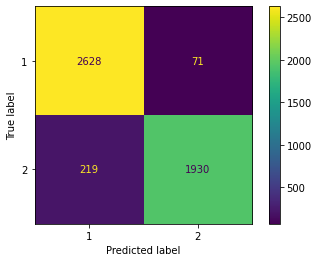

In [ ]:
y_test = test['labels'].values

y_pred_roberta = np.argmax(model_outputs_rbt, axis=1)
print(classification_report(y_test, y_pred_roberta, digits=4))

cm = confusion_matrix(y_test, y_pred_roberta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
disp.plot()
plt.show()

# RoBERTa Classification Model 2

headline + ' [SEP] ' + article_text

In [ ]:
# create function to append article_text to headline by [SEP] token
def append_article_text(headline, article_text):
    return headline + " [SEP] " + article_text

# apply append_article_text function to the dataframe
df['context'] = df.apply(lambda x: append_article_text(x['headline'], x['article_text']), axis=1)
df.head()

,is_sarcastic,headline,article_link,article_text,context
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,"""We are neither post-racial nor post-gender,"" ...",dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,Vegetables don't have to be boring or relegate...,eat your veggies: 9 deliciously different reci...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,"PROVIDENCE, RI—In spite of his best efforts to...",inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,"PATERSON, NJ—Family sources told reporters Tue...",mother comes pretty close to using word 'strea...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...,"Life is cumulative. At the end of our lives, w...",my white inheritance [SEP] Life is cumulative....


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
final_df = df[['is_sarcastic', 'context']]

# renaming the columns of the dataframe to 'label' and 'text'
final_df.rename(columns={'context': 'text', 'is_sarcastic':'labels'}, inplace=True)

# convert the labels to int type
final_df['labels'] = final_df['labels'].astype(int)

# split the dataset into train and test
train, test = model_selection.train_test_split(final_df, test_size=0.2, random_state=42)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
model_rbt = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=2,
    args={'num_train_epochs':5, 'train_batch_size':32, 'max_seq_length':256},
    # use_cuda=False, #if GPU is not available
    cuda_device=0
) 

# Train the model
model_rbt.train_model(train)

# Evaluate the model
result, model_outputs_rbt, wrong_predictions = model_rbt.eval_model(test)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

  0%|          | 0/19392 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/4848 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/606 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0     0.9981    0.9989    0.9985      2699
           1     0.9986    0.9977    0.9981      2149

    accuracy                         0.9983      4848
   macro avg     0.9984    0.9983    0.9983      4848
weighted avg     0.9984    0.9983    0.9983      4848



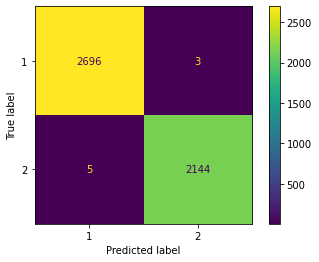

In [ ]:
y_test = test['labels'].values

y_pred_roberta = np.argmax(model_outputs_rbt, axis=1)
print(classification_report(y_test, y_pred_roberta, digits=4))

cm = confusion_matrix(y_test, y_pred_roberta)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,2,3])
disp.plot()
plt.show()

# Plotting the loss curve

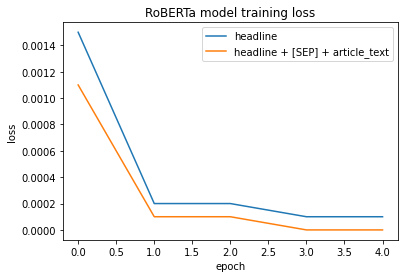

In [ ]:
roberta_headline_article = [0.0011, 0.0001, 0.0001, 0.0000, 0.0000]
roberta_headline = [0.0015, 0.0002, 0.0002, 0.0001, 0.0001]

i = [0, 1, 2, 3, 4]

plt.plot(i, roberta_headline, label='RoBERTa headline')
plt.plot(i, roberta_headline_article, label='RoBERTa headline + article')
plt.title('RoBERTa model training loss')
plt.legend(['headline', 'headline + [SEP] + article_text'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# References

Reference links:

1. Question-answering hugging-face tokenization: https://huggingface.co/course/chapter7/7?fw=pt

2. Question-answering RoBERTa: https://medium.com/mlearning-ai/question-answering-in-association-with-roberta-a11518e70507

3. RoBERTa-base model for Q&A: https://huggingface.co/deepset/roberta-base-squad2

4. Tokenizer documentation: https://huggingface.co/docs/tokenizers/api/tokenizer

5. Using tokenizers in fast-transformers: https://huggingface.co/docs/transformers/fast_tokenizers




Reference papers:

1. Sarcasm Detection using Context Separators in Online Discourse: https://aclanthology.org/2020.figlang-1.6.pdf

2. sQUAD Question Generation: https://arxiv.org/pdf/2005.01107v1.pdf

3. Semi-Supervised Recognition of Sarcastic Sentences: https://aclanthology.org/W10-2914.pdf

4. Identifying Sarcasm in Twitter: https://aclanthology.org/P11-2102.pdf
